In [4]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import sys
from pyspark.sql import SparkSession

In [5]:
spark = SparkSession.builder \
.master("local") \
.appName("Exercise1") \
.getOrCreate()

In [6]:
pwd

'/home/jovyan'

In [7]:
df = spark.read.csv('exampleData.csv', header=True, inferSchema=True)
df.show(n=1, vertical=True)

-RECORD 0--------------------------------
 _c0                 | 14                
 dateTime            | 01-jan-1990 00:00 
 indicator_rain      | 0                 
 precipitation       | 0.3               
 indicator_temp      | 0                 
 air_temperature     | 9.1               
 indicator_wetb      | 0                 
 wetb                | 9.0               
 dewpt               | 8.9               
 vappr               | 11.4              
 relative_humidity   | 99                
 msl                 | 1006.7            
 indicator_wdsp      | 2                 
 wind_speed          | 7                 
 indicator_wddir     | 2                 
 wind_from_direction | 190               
only showing top 1 row



In [8]:
df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- dateTime: string (nullable = true)
 |-- indicator_rain: integer (nullable = true)
 |-- precipitation: string (nullable = true)
 |-- indicator_temp: integer (nullable = true)
 |-- air_temperature: string (nullable = true)
 |-- indicator_wetb: integer (nullable = true)
 |-- wetb: string (nullable = true)
 |-- dewpt: string (nullable = true)
 |-- vappr: string (nullable = true)
 |-- relative_humidity: string (nullable = true)
 |-- msl: string (nullable = true)
 |-- indicator_wdsp: integer (nullable = true)
 |-- wind_speed: string (nullable = true)
 |-- indicator_wddir: integer (nullable = true)
 |-- wind_from_direction: integer (nullable = true)



# Method 1

In [9]:
from pyspark import SparkFiles

url = 'https://cli.fusio.net/cli/climate_data/webdata/hly1075.csv'
spark.sparkContext.addFile(url)

In [10]:
SparkFiles.get('hly1075.csv')

'/tmp/spark-cab2e7c4-fb57-4d02-bc44-c8c1ddf49b7f/userFiles-c4a5a4b1-5703-4f5b-816e-d14ee2cb8788/hly1075.csv'

In [11]:
url_df = spark.read.csv("file://" + SparkFiles.get('hly1075.csv'), header=True, inferSchema=True)
url_df.show()

+--------------------------+
|Station Name: ROCHES POINT|
+--------------------------+
|      Station Height: 4...|
|         Latitude:51.793  |
|      date:  -  Date an...|
|      rain:  -  Precipi...|
|      temp:  -  Air Tem...|
|      wetb:  -  Wet Bul...|
|      dewpt: -  Dew Poi...|
|      vappr: -  Vapour ...|
|      rhum:  -  Relativ...|
|      msl:   -  Mean Se...|
|      wdsp:  -  Mean Wi...|
|      wddir: -  Predomi...|
|       ind:   -  Indicator|
|                      date|
|         01-dec-1955 01:00|
|         01-dec-1955 02:00|
|         01-dec-1955 03:00|
|         01-dec-1955 04:00|
|         01-dec-1955 05:00|
|         01-dec-1955 06:00|
+--------------------------+
only showing top 20 rows



# Method 2

In [17]:
import requests

response = requests.get(url)

if response.status_code == 200:
    local_file_path = 'hly1075.csv'
    
    # Save content to local file
    with open(local_file_path, 'wb') as f:
        f.write(response.content)

    url_df_2 = spark.read.format("csv").option("header", "true").load(local_file_path)
    url_df_2.write.csv('output.csv', header=True)
    
    print("File saved locally:", local_file_path)
else:
    print("Failed to fetch data from the URL:", response.status_code)


37728487

File saved locally: hly1075.csv


In [16]:
import shutil
shutil.rmtree('output.csv', ignore_errors=True)
shutil.rmtree('hly1075.csv', ignore_errors=True)

In [12]:
from pyspark.sql import functions as F 
df.select(F.col("wetb")).count()

245088

In [13]:
df.collect()[3]

Row(_c0=17, dateTime='01-jan-1990 03:00', indicator_rain=3, precipitation='0.0', indicator_temp=0, air_temperature='7.8', indicator_wetb=0, wetb='7.5', dewpt='7.1', vappr='10.1', relative_humidity='96', msl='1007.1', indicator_wdsp=2, wind_speed='1', indicator_wddir=2, wind_from_direction=190)

In [18]:
url_df_2.collect()[5]

Row(Station Name: ROCHES POINT='wetb:  -  Wet Bulb Temperature (C)')

# Monotonically Increasing ID

In [19]:
from pyspark.sql.functions import monotonically_increasing_id
df_with_id = url_df_2.withColumn("ID", monotonically_increasing_id())
df_with_id.show()

+--------------------------+---+
|Station Name: ROCHES POINT| ID|
+--------------------------+---+
|      Station Height: 4...|  0|
|         Latitude:51.793  |  1|
|      date:  -  Date an...|  2|
|      rain:  -  Precipi...|  3|
|      temp:  -  Air Tem...|  4|
|      wetb:  -  Wet Bul...|  5|
|      dewpt: -  Dew Poi...|  6|
|      vappr: -  Vapour ...|  7|
|      rhum:  -  Relativ...|  8|
|      msl:   -  Mean Se...|  9|
|      wdsp:  -  Mean Wi...| 10|
|      wddir: -  Predomi...| 11|
|       ind:   -  Indicator| 12|
|                      date| 13|
|         01-dec-1955 01:00| 14|
|         01-dec-1955 02:00| 15|
|         01-dec-1955 03:00| 16|
|         01-dec-1955 04:00| 17|
|         01-dec-1955 05:00| 18|
|         01-dec-1955 06:00| 19|
+--------------------------+---+
only showing top 20 rows



## Accessing Rows after ID col

In [20]:
print(df_with_id.collect()[3])
print(df_with_id.collect()[6])
print(df_with_id.collect()[9])

Row(Station Name: ROCHES POINT='rain:  -  Precipitation Amount (mm)\t  ', ID=3)
Row(Station Name: ROCHES POINT='dewpt: -  Dew Point Temperature (C)', ID=6)
Row(Station Name: ROCHES POINT='msl:   -  Mean Sea Level Pressure (hPa)', ID=9)


## With Distinct

In [21]:
df.select("wetb").count()
df.select("wetb").distinct() #Allows you to select only distinct values
df.select("wetb").distinct().count() #count of distinct values

245088

DataFrame[wetb: string]

264

## Without Distinct

In [22]:
df.select("wetb").count()
df.select("wetb") #Allows you to select only distinct values
df.select("wetb").count() #count of distinct values

245088

DataFrame[wetb: string]

245088

## Only the whole dataframe (Distinct)

In [23]:
df.distinct()

DataFrame[_c0: int, dateTime: string, indicator_rain: int, precipitation: string, indicator_temp: int, air_temperature: string, indicator_wetb: int, wetb: string, dewpt: string, vappr: string, relative_humidity: string, msl: string, indicator_wdsp: int, wind_speed: string, indicator_wddir: int, wind_from_direction: int]

In [24]:
df.selectExpr("wetb * 5 as newColumn", "round(air_temperature) as roundedTemper").show()

+---------+-------------+
|newColumn|roundedTemper|
+---------+-------------+
|     45.0|          9.0|
|     37.0|          8.0|
|     37.0|          8.0|
|     37.5|          8.0|
|     36.5|          8.0|
|     35.0|          8.0|
|     34.0|          7.0|
|     30.0|          7.0|
|     31.0|          7.0|
|     30.5|          7.0|
|     30.5|          8.0|
|     33.0|          8.0|
|     39.0|         10.0|
|     35.0|          9.0|
|     40.0|         10.0|
|     37.5|          9.0|
|     35.5|          9.0|
|     33.0|          8.0|
|     35.5|          9.0|
|     34.0|          8.0|
+---------+-------------+
only showing top 20 rows



In [25]:
df0 = df.selectExpr("wetb as wetbulb")
df0.show()

+-------+
|wetbulb|
+-------+
|    9.0|
|    7.4|
|    7.4|
|    7.5|
|    7.3|
|    7.0|
|    6.8|
|    6.0|
|    6.2|
|    6.1|
|    6.1|
|    6.6|
|    7.8|
|    7.0|
|    8.0|
|    7.5|
|    7.1|
|    6.6|
|    7.1|
|    6.8|
+-------+
only showing top 20 rows



In [26]:
df.drop("_c0")

DataFrame[dateTime: string, indicator_rain: int, precipitation: string, indicator_temp: int, air_temperature: string, indicator_wetb: int, wetb: string, dewpt: string, vappr: string, relative_humidity: string, msl: string, indicator_wdsp: int, wind_speed: string, indicator_wddir: int, wind_from_direction: int]

In [27]:
df.withColumn("air_temperature",F.round(df["air_temperature"],
1)).show()

+---+-----------------+--------------+-------------+--------------+---------------+--------------+----+-----+-----+-----------------+------+--------------+----------+---------------+-------------------+
|_c0|         dateTime|indicator_rain|precipitation|indicator_temp|air_temperature|indicator_wetb|wetb|dewpt|vappr|relative_humidity|   msl|indicator_wdsp|wind_speed|indicator_wddir|wind_from_direction|
+---+-----------------+--------------+-------------+--------------+---------------+--------------+----+-----+-----+-----------------+------+--------------+----------+---------------+-------------------+
| 14|01-jan-1990 00:00|             0|          0.3|             0|            9.1|             0| 9.0|  8.9| 11.4|               99|1006.7|             2|         7|              2|                190|
| 15|01-jan-1990 01:00|             0|          0.2|             0|            8.2|             0| 7.4|  6.4|  9.7|               89|1006.7|             2|         5|              2|      

In [28]:
df1 = df.selectExpr("cast(air_temperature as float) air_temperature")
df1.dtypes

[('air_temperature', 'float')]

In [29]:
df_new = df.filter((F.col('air_temperature')<5)).show()
df_new

+---+-----------------+--------------+-------------+--------------+---------------+--------------+----+-----+-----+-----------------+------+--------------+----------+---------------+-------------------+
|_c0|         dateTime|indicator_rain|precipitation|indicator_temp|air_temperature|indicator_wetb|wetb|dewpt|vappr|relative_humidity|   msl|indicator_wdsp|wind_speed|indicator_wddir|wind_from_direction|
+---+-----------------+--------------+-------------+--------------+---------------+--------------+----+-----+-----+-----------------+------+--------------+----------+---------------+-------------------+
|298|12-jan-1990 20:00|             3|          0.0|             0|            4.9|             0| 4.3|  3.4|  7.8|               90|1025.5|             2|         1|              2|                210|
|300|12-jan-1990 22:00|             3|          0.0|             0|            3.9|             0| 3.2|  2.1|  7.1|               88|1025.9|             2|         1|              2|      

## Precipitation > 1

In [30]:
df_precipitation = df.filter((F.col('precipitation') > 1)).show()
df_precipitation

+----+-----------------+--------------+-------------+--------------+---------------+--------------+----+-----+-----+-----------------+------+--------------+----------+---------------+-------------------+
| _c0|         dateTime|indicator_rain|precipitation|indicator_temp|air_temperature|indicator_wetb|wetb|dewpt|vappr|relative_humidity|   msl|indicator_wdsp|wind_speed|indicator_wddir|wind_from_direction|
+----+-----------------+--------------+-------------+--------------+---------------+--------------+----+-----+-----+-----------------+------+--------------+----------+---------------+-------------------+
|  40|02-jan-1990 02:00|             0|          5.8|             0|            7.5|             0| 7.2|  6.8|  9.9|               96|1003.8|             2|        26|              2|                140|
| 327|14-jan-1990 01:00|             0|          2.3|             0|            8.7|             0| 8.1|  7.5| 10.3|               92|1015.1|             2|        12|              2| 

## Precipitation > 1 and Temperature < 5

In [31]:
df_prec_temp = df.filter((F.col('precipitation') > 1) & (F.col('air_temperature') < 5)).show()
df_prec_temp

+-----+-----------------+--------------+-------------+--------------+---------------+--------------+----+-----+-----+-----------------+------+--------------+----------+---------------+-------------------+
|  _c0|         dateTime|indicator_rain|precipitation|indicator_temp|air_temperature|indicator_wetb|wetb|dewpt|vappr|relative_humidity|   msl|indicator_wdsp|wind_speed|indicator_wddir|wind_from_direction|
+-----+-----------------+--------------+-------------+--------------+---------------+--------------+----+-----+-----+-----------------+------+--------------+----------+---------------+-------------------+
| 8752|31-dec-1990 02:00|             0|          2.2|             0|            4.7|             0| 4.5|  4.2|  8.3|               97|1006.6|             2|         1|              2|                330|
| 9103|14-feb-1993 17:00|             0|          2.8|             0|            0.0|             4|    |     |     |                 |      |             1|        10|            

## WHERE Clause - Task

In [32]:
df_prec_gt_1mm = df.where(df['precipitation'] > 1)
df_filtered = df.union(df_prec_gt_1mm)
df_filtered.show()

+---+-----------------+--------------+-------------+--------------+---------------+--------------+----+-----+-----+-----------------+------+--------------+----------+---------------+-------------------+
|_c0|         dateTime|indicator_rain|precipitation|indicator_temp|air_temperature|indicator_wetb|wetb|dewpt|vappr|relative_humidity|   msl|indicator_wdsp|wind_speed|indicator_wddir|wind_from_direction|
+---+-----------------+--------------+-------------+--------------+---------------+--------------+----+-----+-----+-----------------+------+--------------+----------+---------------+-------------------+
| 14|01-jan-1990 00:00|             0|          0.3|             0|            9.1|             0| 9.0|  8.9| 11.4|               99|1006.7|             2|         7|              2|                190|
| 15|01-jan-1990 01:00|             0|          0.2|             0|            8.2|             0| 7.4|  6.4|  9.7|               89|1006.7|             2|         5|              2|      

In [33]:
df_u = df.select("wetb")
df_i = df.select("air_temperature")
unionDF = df_u.union(df_i)
unionDF

DataFrame[wetb: string]

In [34]:
df.groupBy('precipitation').count().orderBy('count',
ascending=False).show()

+-------------+------+
|precipitation| count|
+-------------+------+
|          0.0|218530|
|          0.2|  5928|
|          0.1|  5129|
|          0.4|  2621|
|          0.6|  1663|
|          0.3|  1330|
|          0.8|  1220|
|          1.0|   917|
|          0.5|   786|
|          1.2|   718|
|          1.4|   558|
|          0.7|   532|
|          1.6|   503|
|             |   384|
|          1.8|   359|
|          0.9|   356|
|          2.0|   312|
|          1.1|   282|
|          1.3|   244|
|          2.2|   238|
+-------------+------+
only showing top 20 rows



# SQL

In [35]:
df.registerTempTable("example")

/usr/local/spark/python/pyspark/sql/dataframe.py:138: FutureWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
  warnings.warn(


In [36]:
pr = spark.sql("Select air_temperature, count(air_temperature) AS total_freq, count(distinct air_temperature) AS unique_air_temp, count(wetb) AS wetb_freq,count(distinct wetb) AS unique_wetb FROM example GROUP BY air_temperature")
pr.show()

+---------------+----------+---------------+---------+-----------+
|air_temperature|total_freq|unique_air_temp|wetb_freq|unique_wetb|
+---------------+----------+---------------+---------+-----------+
|           10.7|      1926|              1|     1926|         48|
|            8.5|      1761|              1|     1761|         44|
|           20.5|        70|              1|       70|         33|
|           -1.2|        24|              1|       24|         12|
|            1.0|        93|              1|       93|         20|
|            8.2|      1560|              1|     1560|         45|
|            2.6|       342|              1|      342|         29|
|            7.3|      1230|              1|     1230|         43|
|            3.1|       464|              1|      464|         31|
|           16.6|       994|              1|      994|         51|
|           12.8|      1623|              1|     1623|         48|
|           14.2|      1655|              1|     1655|        

## SQL CONTEXT

In [37]:
sql_df = spark.read.csv("exampleData.csv", header=True, inferSchema=True)
sql_df.createOrReplaceTempView("example")

spr = spark.sql("""
    SELECT 
        air_temperature, 
        count(air_temperature) AS total_freq,
        count(distinct air_temperature) AS unique_air_temp, 
        count(wetb) AS wetb_freq,
        count(distinct wetb) AS unique_wetb 
    FROM 
        example 
    GROUP BY 
        air_temperature
""")

spr.show()
sql_df.write.saveAsTable("example_table")


+---------------+----------+---------------+---------+-----------+
|air_temperature|total_freq|unique_air_temp|wetb_freq|unique_wetb|
+---------------+----------+---------------+---------+-----------+
|           10.7|      1926|              1|     1926|         48|
|            8.5|      1761|              1|     1761|         44|
|           20.5|        70|              1|       70|         33|
|           -1.2|        24|              1|       24|         12|
|            1.0|        93|              1|       93|         20|
|            8.2|      1560|              1|     1560|         45|
|            2.6|       342|              1|      342|         29|
|            7.3|      1230|              1|     1230|         43|
|            3.1|       464|              1|      464|         31|
|           16.6|       994|              1|      994|         51|
|           12.8|      1623|              1|     1623|         48|
|           14.2|      1655|              1|     1655|        

AnalysisException: Can not create the managed table('`example_table`'). The associated location('file:/home/jovyan/spark-warehouse/example_table') already exists.

# Visualizations

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

<AxesSubplot:xlabel='precipitation', ylabel='air_temperature'>

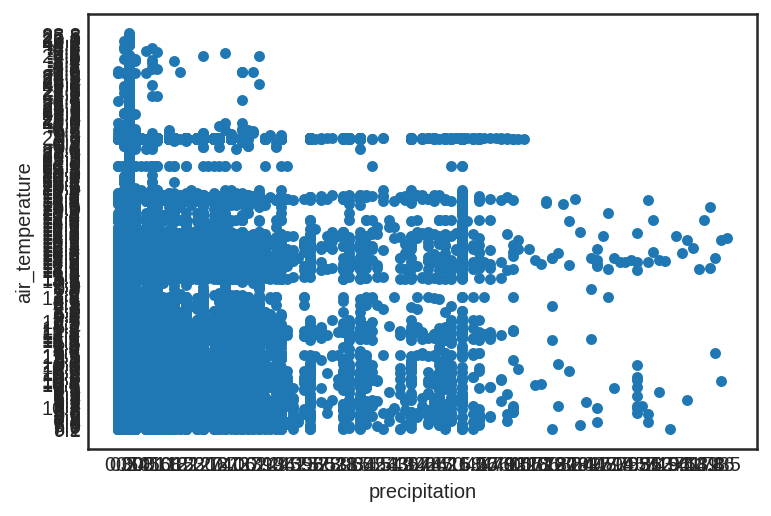

In [39]:
dff = df.toPandas()
params = {'legend.fontsize': 'large',
'figure.figsize': (15, 9),
'axes.labelsize': 'x-large',
'axes.titlesize':'x-large',
'xtick.labelsize':'large',
'ytick.labelsize':'large'}
dff.plot(kind='scatter',x='precipitation',y='air_temperature')
#This will most likely give a type error because of dtype object, you can use the following code to convert object data to numerical type. This code should be called before the plot line above.
dff['precipitation'] = pd.to_numeric(dff.precipitation,errors='coerce')
dff['air_temperature'] = pd.to_numeric(dff.air_temperature,errors='coerce')

<AxesSubplot:xlabel='precipitation', ylabel='air_temperature'>

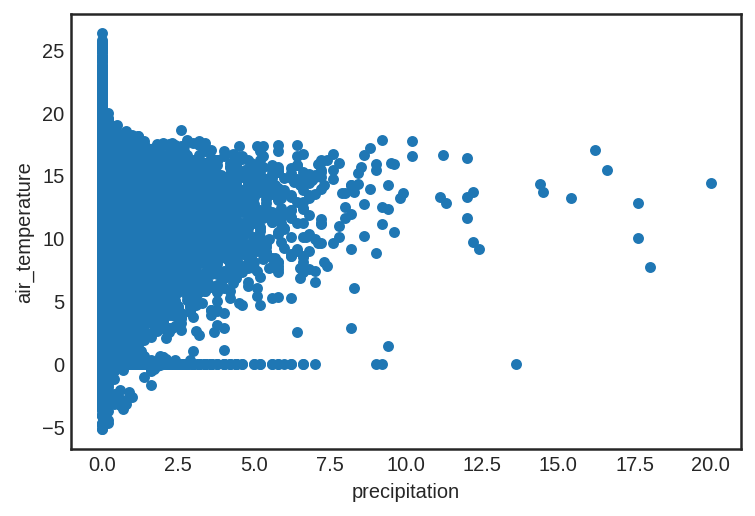

In [81]:
subset_df = dff.sample(n=100)
dff.plot(kind='scatter',x='precipitation',y='air_temperature')

Text(0.5, 1.0, 'Air Temperature Over Time (Subset)')

Text(0.5, 0, 'DateTime')

Text(0, 0.5, 'Air Temperature')

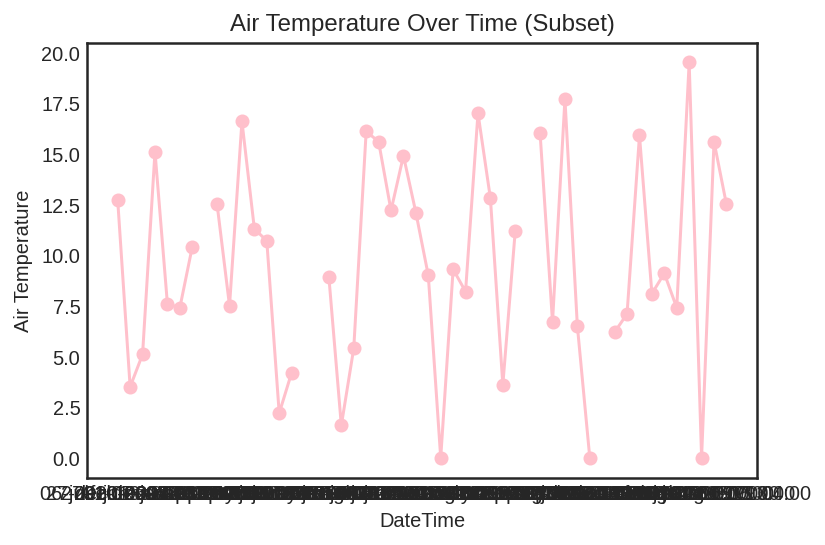

In [49]:
subset_df = dff.sample(n=50)
plt.title('Air Temperature Over Time (Subset)')
plt.xlabel('DateTime') 
plt.ylabel('Air Temperature')
plt.plot(subset_df['dateTime'], subset_df['air_temperature'], color='pink', marker='o', linestyle='-')

<AxesSubplot:xlabel='relative_humidity', ylabel='wind_speed'>

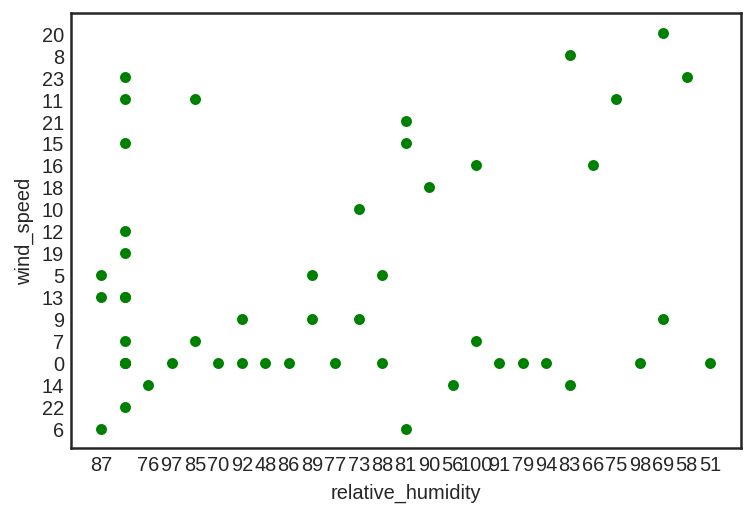

In [61]:
subset_df.plot(kind='scatter', x='relative_humidity', y='wind_speed', color='green')

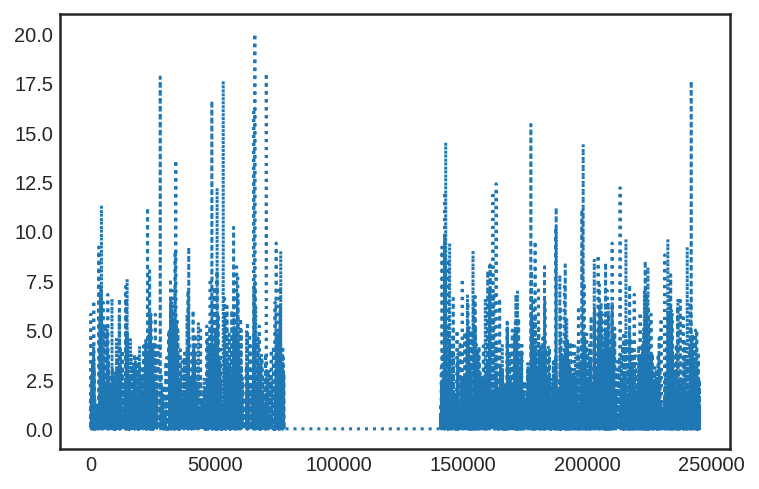

In [69]:
plt.plot(dff['precipitation'], linestyle = 'dotted')

(array([2., 2., 2., 2., 1., 3., 2., 2., 2., 2.]),
 array([ 0. ,  1.8,  3.6,  5.4,  7.2,  9. , 10.8, 12.6, 14.4, 16.2, 18. ]),
 <BarContainer object of 10 artists>)

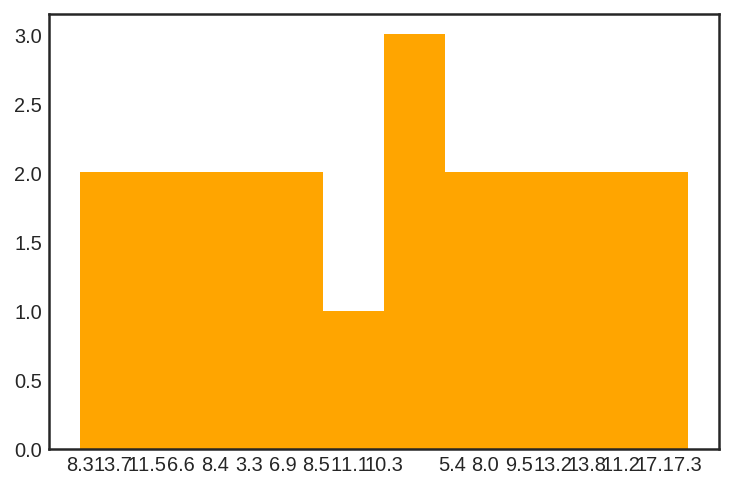

In [77]:
subset_df = dff.sample(n=20)
plt.hist(subset_df['wetb'], color='orange')

(array([8., 2., 1., 1., 3., 1., 1., 1., 1., 1.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

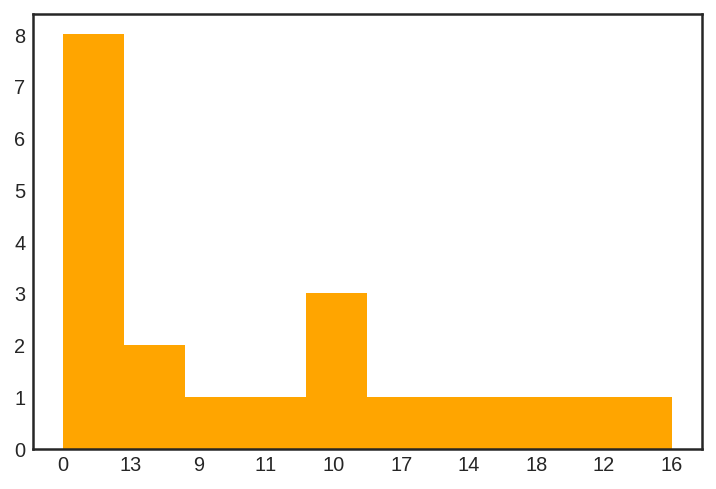

In [78]:
subset_df = dff.sample(n=20)
plt.hist(subset_df['wind_speed'], color='orange')

(array([2., 1., 2., 4., 4., 1., 2., 1., 1., 2.]),
 array([ 0. ,  1.3,  2.6,  3.9,  5.2,  6.5,  7.8,  9.1, 10.4, 11.7, 13. ]),
 <BarContainer object of 10 artists>)

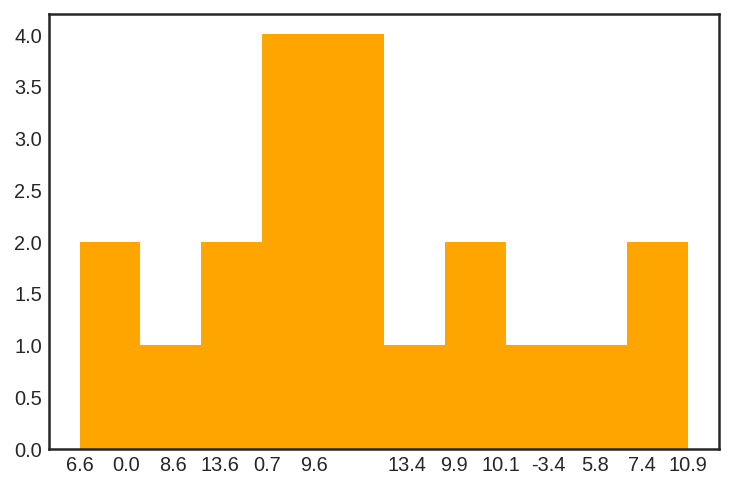

In [79]:
subset_df = dff.sample(n=20)
plt.hist(subset_df['dewpt'], color='orange')

(array([2., 6., 2., 1., 1., 2., 1., 2., 1., 2.]),
 array([ 0. ,  1.4,  2.8,  4.2,  5.6,  7. ,  8.4,  9.8, 11.2, 12.6, 14. ]),
 <BarContainer object of 10 artists>)

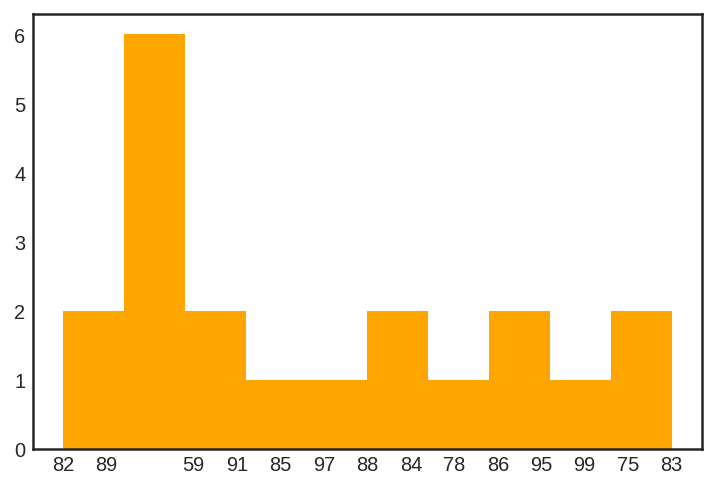

In [80]:
subset_df = dff.sample(n=20)
plt.hist(subset_df['relative_humidity'], color='orange')